# CONV nets to predict survival using gene expression data

In this notebook we use convolutional neural networks to predict overall survival by using gene expression data. For this propose, we start from a dataset composed of 20K genes (that have been previously prefiltered (using std and MAD scores). The RNA-seq expression samples are embedded (transformed) into 2D images and fed into a deep architecture composed of convolutional layers.

See Lyu, B., and A. Haque. 2018. “Deep Learning Based Tumor Type Classification Using Gene Expression Data.” Proceedings of the 2018 ACM International. https://dl.acm.org/citation.cfm?id=3233588.

# PanCancer data

First, we download the RSEM TPM gene expression data from https://toil.xenahubs.net/download/tcga_RSEM_gene_tpm.gz. The format of the gene expression data is log2(TPM+0.001).

In order to apply the transfer-learning approach, we need to split the PanCancer gene expression dataset into two substets: non-BRCA and BRCA datasets.

TCGA BRCA study samples information has been downloaded from https://tcga.xenahubs.net/download/TCGA.BRCA.sampleMap/BRCA_clinicalMatrix

## Genes filtering

As the raw PanCancer gene expression dataset contains a number of initial genes (60K) impossible to deal with, we have reduced the number of variables, using the non-BRCA PanCancer dataset, which will be used to pre-train DL models. The genes we keep using the non-BRCA dataset will also be kept in the BRCA dataset, which will be used to fine-tune the models. We have used standard deviation and MAD (Median Absolute Deviation) to filter those less significant genes.

### Genes pre-filtering

As not all the 60K genes are informative, firstly, we filter out the ones with constant expression values across samples, using the standard deviation measure.

### Unsupervised feature selection

As the number of genes remains too large after the removal of the constant genes, we need to pre-filter more variables. To do that, we will apply an unsupervised filter method based on the Median Absolute Deviation (MAD), the metric used to rank the genes.

**See the following notebooks:**
- ~/DeepLearning-Bioinformatics/pre-processing/PanCancer-Gene-Filtering.ipynb
- ~/DeepLearning-Bioinformatics/pre-processing/PanCancer-TPM-BRCA-Split.ipynb

#### Load BRCA and NON-BRCA filtered datasets

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

np.random.seed(123456) # For reproductivity purposes

##### Load gene expression data:

In [4]:
%%time

brca_ex = pd.read_hdf("../data/TCGA_gene_exp_20k_std-MAD.h5", key = "brca")
non_brca_ex = pd.read_hdf("../data/TCGA_gene_exp_20k_std-MAD.h5", key = "non_brca")

CPU times: user 124 ms, sys: 498 ms, total: 621 ms
Wall time: 625 ms


In [4]:
sum(brca_ex.isnull().any(axis=1))

0

##### Load Clinical info:

In [5]:
%%time

brca_clinical = pd.read_hdf("../data/TCGA_data.h5", key = "brca_clinical")
non_brca_clinical  = pd.read_hdf("../data/TCGA_data.h5", key = "non_brca_clinical")

CPU times: user 37.6 ms, sys: 7.67 ms, total: 45.3 ms
Wall time: 44.5 ms


#### Data exploration

In [ ]:
brca_ex.shape

In [ ]:
brca_ex.head()

In [ ]:
brca_ex.describe()

In [ ]:
non_brca_ex.shape

In [ ]:
non_brca_ex.head()

In [ ]:
non_brca_ex.describe()

In [ ]:
brca_clinical.shape

In [ ]:
brca_clinical.head()

In [ ]:
brca_clinical.describe()

In [ ]:
non_brca_clinical.shape

In [ ]:
non_brca_clinical.head()

In [ ]:
non_brca_clinical.describe()

## Download genes information

We download biological information associated to each gene from an Ensemble-Hugo gene name mapping table, which we call gene info dataset https://raw.githubusercontent.com/jvivian/docker_tools/master/gencode_hugo_mapping/attrs.tsv

In [6]:
ens_hugo = pd.read_csv('../data/hugo_ensembl.tsv', sep='\t', engine='python', index_col=0)

In [ ]:
ens_hugo.shape

In [ ]:
ens_hugo.head()

We now filter from the gene info dataset, the genes IDs contained in our expression dataset:

In [7]:
ens_hugo = ens_hugo[~ens_hugo.index.duplicated()]

common_genes = ens_hugo.index.intersection(brca_ex.columns)
ens_hugo = ens_hugo.loc[common_genes, :]

len(common_genes)

20000

In [ ]:
ens_hugo.shape

We now check the distribution of the different Ensembl gene types (https://www.ensembl.org/info/genome/genebuild/biotypes.html) contained in our expression dataset:

In [ ]:
gene_type_dist = ens_hugo.geneType.value_counts()
gene_type_dist

In [ ]:
# We group the pseudogenes, IG and TR types, to reduce the number of gene types
ens_hugo["geneType_short"] = ens_hugo.geneType.apply(
    lambda x: "pseudogene" if x.split('_')[-1] == "pseudogene" else "IG" if x.split('_')[0] == "IG"
    else "TR" if x.split('_')[0] == "TR" else x)

In [ ]:
short_common_gene_type_dist = ens_hugo.geneType_short.value_counts()
short_common_gene_type_dist

In [ ]:
import plotly as py
import plotly.graph_objs as go

py.offline.init_notebook_mode()

In [ ]:
labels = short_common_gene_type_dist.index
values = short_common_gene_type_dist.values

trace = go.Pie(labels=labels, values=values)

py.offline.iplot([trace])

### Convert Ensemble IDs to Hugo gene names

First, we need to verify that the cardinality of the relationship between the Hugo gene names and the Ensemble IDs is 1:N:

In [8]:
ens_hugo_name = pd.DataFrame({"geneId": ens_hugo.index, "geneName": ens_hugo["geneName"].values})

# First remove duplicate, then sort
ens_hugo_name = ens_hugo_name[~ens_hugo_name.duplicated()]
ens_hugo_name = ens_hugo_name.sort_values(by=["geneId", "geneName"])
ens_hugo_name.head()

,geneId,geneName
19713,ENSG00000000003.14,TSPAN6
19712,ENSG00000000005.5,TNMD
1461,ENSG00000000460.16,C1orf112
372,ENSG00000000938.12,FGR
1582,ENSG00000000971.15,CFH


Ensemble IDs to Hugo gene names relationship:

In [9]:
ens_hugo_name.geneId.value_counts(sort=True, ascending=False)[:10]

ENSG00000189320.8     1
ENSG00000242687.2     1
ENSG00000136869.13    1
ENSG00000136244.11    1
ENSG00000188825.13    1
ENSG00000257008.6     1
ENSG00000271079.1     1
ENSG00000124935.3     1
ENSG00000165023.5     1
ENSG00000101493.10    1
Name: geneId, dtype: int64

Hugo gene names to Ensemble IDs relationship:

In [10]:
ens_hugo_name.geneName.value_counts(sort=True, ascending=False)[:10]

Metazoa_SRP    8
RNA5-8S5       4
TRPV1          2
SNX29P2        2
ELFN2          2
SPATA13        2
CROCCP2        2
C2orf15        2
RPPH1          2
ICOSLG         2
Name: geneName, dtype: int64

As it was stated before, multiple Ensemble IDs correpond to one Hugo gene name, but only one Hugo gene name corresponds to one Ensemble ID. We now create a gene expression data frame in which the row labels are the Hugo gene names:

In [11]:
# Remove duplicate Ensemble IDs
ens_hugo = ens_hugo[~ens_hugo.index.duplicated()]
ens_hugo.head()

,geneName,geneType,geneStatus,transcriptId,transcriptName,transcriptType,transcriptStatus,havanaGeneId,havanaTranscriptId,ccdsId,level,transcriptClass
ENSG00000227232.5,WASH7P,unprocessed_pseudogene,KNOWN,ENST00000488147.1,WASH7P-001,unprocessed_pseudogene,KNOWN,OTTHUMG00000000958.1,OTTHUMT00000002839.1,NaN,2,pseudo
ENSG00000238009.6,RP11-34P13.7,lincRNA,KNOWN,ENST00000466430.5,RP11-34P13.7-001,lincRNA,KNOWN,OTTHUMG00000001096.2,OTTHUMT00000003225.1,NaN,2,nonCoding
ENSG00000239945.1,RP11-34P13.8,lincRNA,KNOWN,ENST00000495576.1,RP11-34P13.8-001,lincRNA,KNOWN,OTTHUMG00000001097.2,OTTHUMT00000003226.2,NaN,2,nonCoding
ENSG00000233750.3,CICP27,processed_pseudogene,KNOWN,ENST00000442987.3,CICP27-001,processed_pseudogene,KNOWN,OTTHUMG00000001257.3,OTTHUMT00000003691.3,NaN,1,pseudo
ENSG00000268903.1,RP11-34P13.15,processed_pseudogene,KNOWN,ENST00000494149.2,RP11-34P13.15-001,processed_pseudogene,KNOWN,OTTHUMG00000182518.2,OTTHUMT00000461982.2,NaN,1,pseudo


In [12]:
hugo_non_brca_ex = non_brca_ex.copy()
hugo_brca_ex = brca_ex.copy()

hugo_non_brca_ex.columns = ens_hugo.reindex(non_brca_ex.columns).geneName.values
hugo_brca_ex.columns = ens_hugo.reindex(non_brca_ex.columns).geneName.values

In [13]:
hugo_non_brca_ex.head()

,AC005943.6,TFF1,RP11-162P23.2,CEACAM5,IGHV1-3,KLK8,S100A7,MIR205HG,IGKV1-39,TXLNGY,...,FAM193B,C1RL,LRRC16A,NUDT6,NCOA3,RNPC3,NR2C2,XRN1,RPL24P4,TAF1
TCGA-EE-A2GP-06,-9.966,-9.966,-9.9660,-3.626,-9.966,-2.635,-9.966,-9.966,0.346,3.9000,...,5.073,3.6750,4.2050,2.703,3.9380,4.224,4.920,3.3720,2.830,4.6140
TCGA-OR-A5J1-01,5.583,-9.966,-9.9660,-9.966,-9.966,-9.966,-9.966,-6.506,-9.966,4.0420,...,6.174,-0.4719,3.4790,1.836,1.2090,1.762,2.214,1.2520,4.094,1.6790
TCGA-HG-A2PA-01,-9.966,5.678,-9.9660,8.201,6.907,1.820,8.188,8.267,1.758,-9.9660,...,4.023,4.4630,2.5850,2.018,3.2050,2.734,2.245,3.2330,3.334,3.6420
TCGA-AB-2854-03,-9.966,-9.966,-9.9660,-9.966,3.515,-9.966,-9.966,-9.966,4.321,-9.9660,...,6.325,4.2210,-0.3752,2.899,3.8360,4.955,5.022,3.7530,3.172,4.4570
TCGA-DD-A3A8-11,-9.966,-9.966,0.0014,-2.178,2.731,-9.966,-9.966,-9.966,-0.394,0.4125,...,1.171,5.6190,-0.7108,2.649,0.4967,-1.470,-1.026,-0.4325,2.186,-0.2159


In [14]:
hugo_non_brca_ex = hugo_non_brca_ex.sort_index(axis=0).sort_index(axis=1)
hugo_brca_ex = hugo_brca_ex.sort_index(axis=0).sort_index(axis=1)

Delete duplicated gene ids:

In [15]:
hugo_non_brca_ex = hugo_non_brca_ex.loc[:, ~hugo_non_brca_ex.columns.duplicated()]
hugo_brca_ex = hugo_brca_ex.loc[:, ~hugo_brca_ex.columns.duplicated()]

In [16]:
print("non_brca_ex.shape:", non_brca_ex.shape)
print("brca_ex.shape:", brca_ex.shape)
print("hugo_non_brca_ex.shape:", hugo_non_brca_ex.shape)
print("hugo_brca_ex.shape:", hugo_brca_ex.shape)

non_brca_ex.shape: (9285, 20000)
brca_ex.shape: (1212, 20000)
hugo_non_brca_ex.shape: (9285, 19959)
hugo_brca_ex.shape: (1212, 19959)


#### Get survival data from OS and OS_time variables
Convert each patient's output data from (time, censoring indicator) format to a vector that for each time interval specifies whether the patient survived that time interval, and whether the patient failed during that time interval:

Preprocess OS information to drop NaN values and convert string values into float

In [17]:
# Deleting samples with 'NaN's in OS-columns 

## non_brca
non_brca_clinical['OS.time'] = non_brca_clinical['OS.time'].map(lambda x: np.nan if x == 'NaN' else x)
non_brca_clinical['OS'] = non_brca_clinical['OS'].map(lambda x: np.nan if x == 'NaN' else x)
non_brca_clinical.dropna(subset=['OS.time', 'OS'], inplace=True)
non_brca_clinical['OS.time'] = non_brca_clinical['OS.time'].astype(float)
non_brca_clinical['OS'] = non_brca_clinical['OS'].astype(float)

## brca
brca_clinical['OS.time'] = brca_clinical['OS.time'].map(lambda x: np.nan if x == 'NaN' else x)
brca_clinical['OS'] = brca_clinical['OS'].map(lambda x: np.nan if x == 'NaN' else x)
brca_clinical.dropna(subset=['OS.time', 'OS'], inplace=True)
brca_clinical['OS.time'] = brca_clinical['OS.time'].astype(float)
brca_clinical['OS'] = brca_clinical['OS'].astype(float)

In [18]:
non_brca_common_index = non_brca_clinical.index.intersection(non_brca_ex.index)

In [19]:
len(non_brca_common_index)

9224

In [20]:
non_brca_ex = non_brca_ex.reindex(non_brca_common_index)
non_brca_clinical = non_brca_clinical.reindex(non_brca_common_index)

In [21]:
brca_common_index = brca_clinical.index.intersection(brca_ex.index)

In [22]:
len(brca_common_index)

1196

In [23]:
brca_ex = brca_ex.reindex(brca_common_index)
brca_clinical = brca_clinical.reindex(brca_common_index)

Transforms censored survival data into vector:

In [24]:
# Create 39 equally spaced intervals for follow-up time, from 0 to 5 years:
breaks = np.arange(0.,365.*5,365./8)
n_intervals = len(breaks)-1
timegap = breaks[1:] - breaks[:-1]

In [25]:
import nnet_survival

Using TensorFlow backend.


In [26]:
non_brca_y = nnet_survival.make_surv_array(non_brca_clinical['OS.time'],
                             non_brca_clinical['OS'],
                             breaks)

In [27]:
brca_y = nnet_survival.make_surv_array(brca_clinical['OS.time'], brca_clinical.OS,breaks)

## Manage pathway information associated to each gene

#### Load Kegg pathway gene list
(see Gene_group_pathways.ipynb)

In [28]:
pw_gene_list = np.load('../data/pw_gene_list.npy').item()

In [29]:
pw_gene_list

{'path:hsa00010': [('3101', 'HK3'),
  ('3098', 'HK1'),
  ('3099', 'HK2'),
  ('80201', 'HKDC1'),
  ('2645', 'GCK'),
  ('2821', 'GPI'),
  ('5213', 'PFKM'),
  ('5214', 'PFKP'),
  ('5211', 'PFKL'),
  ('2203', 'FBP1'),
  ('8789', 'FBP2'),
  ('230', 'ALDOC'),
  ('226', 'ALDOA'),
  ('229', 'ALDOB'),
  ('7167', 'TPI1'),
  ('2597', 'GAPDH'),
  ('26330', 'GAPDHS'),
  ('5232', 'PGK2'),
  ('5230', 'PGK1'),
  ('5223', 'PGAM1'),
  ('5224', 'PGAM2'),
  ('441531', 'PGAM4'),
  ('2027', 'ENO3'),
  ('2026', 'ENO2'),
  ('2023', 'ENO1'),
  ('387712', 'ENO4'),
  ('5315', 'PKM'),
  ('5313', 'PKLR'),
  ('5161', 'PDHA2'),
  ('5160', 'PDHA1'),
  ('5162', 'PDHB'),
  ('1737', 'DLAT'),
  ('1738', 'DLD'),
  ('160287', 'LDHAL6A'),
  ('92483', 'LDHAL6B'),
  ('3939', 'LDHA'),
  ('3945', 'LDHB'),
  ('3948', 'LDHC'),
  ('124', 'ADH1A'),
  ('125', 'ADH1B'),
  ('126', 'ADH1C'),
  ('131', 'ADH7'),
  ('127', 'ADH4'),
  ('128', 'ADH5'),
  ('130', 'ADH6'),
  ('10327', 'AKR1A1'),
  ('217', 'ALDH2'),
  ('224', 'ALDH3A2'),
  ('2

In [30]:
# List of all genes in the pathways
print("Number of Kegg pathways:", len(pw_gene_list))
gene_list = [item[1] for l in pw_gene_list.values() for item in l]
print("Kegg pathways include", len(gene_list), "genes (with overlap)")
gene_list = list(set(gene_list))
print("Kegg pathways include", len(gene_list), "different genes")

Number of Kegg pathways: 321
Kegg pathways include 28112 genes (with overlap)
Kegg pathways include 7446 different genes


In [31]:
pancan_genes_in_pw = []
for g in hugo_brca_ex.columns:
    if g in gene_list:
        pancan_genes_in_pw.append(g)

In [32]:
print("Number of genes in pancan dataset with Kegg pathways:", len(pancan_genes_in_pw))

Number of genes in pancan dataset with Kegg pathways: 3865


List of genes for each Pancan pathway:

In [33]:
pancan_pws_genes = {} # List of genes for each pancan pw
for pw in pw_gene_list:
    genes = [gen[1] for gen in pw_gene_list[pw]]
    l = []
    for g in hugo_brca_ex.columns:
        if g in genes:
            l.append(g)
    pancan_pws_genes[pw] = l

In [34]:
pancan_pws_genes

{'path:hsa00010': ['ACSS1',
  'ADH1A',
  'ADH1B',
  'ADH1C',
  'ADH4',
  'ADH6',
  'ALDH1A3',
  'ALDH1B1',
  'ALDH2',
  'ALDH3A1',
  'ALDH3A2',
  'ALDH3B1',
  'ALDH3B2',
  'ALDH7A1',
  'ALDOB',
  'ALDOC',
  'ENO1',
  'ENO2',
  'ENO3',
  'ENO4',
  'FBP1',
  'FBP2',
  'GALM',
  'GAPDH',
  'GCK',
  'HK2',
  'HK3',
  'HKDC1',
  'LDHA',
  'LDHAL6A',
  'LDHAL6B',
  'LDHB',
  'LDHC',
  'PCK1',
  'PCK2',
  'PFKM',
  'PFKP',
  'PGAM2',
  'PGAM4',
  'PGK1',
  'PGM2',
  'PKLR',
  'PKM'],
 'path:hsa00020': ['IDH1', 'IDH2', 'OGDHL', 'PC', 'PCK1', 'PCK2'],
 'path:hsa00030': ['ALDOB',
  'ALDOC',
  'FBP1',
  'FBP2',
  'GLYCTK',
  'IDNK',
  'PFKM',
  'PFKP',
  'PGM2',
  'RBKS',
  'RGN',
  'RPEL1',
  'TKTL1'],
 'path:hsa00040': ['AKR1B1',
  'AKR1B10',
  'CRYL1',
  'DCXR',
  'DHDH',
  'ISPD',
  'KL',
  'RPEL1',
  'SORD',
  'UGDH',
  'UGT1A1',
  'UGT1A10',
  'UGT1A6',
  'UGT1A7',
  'UGT2B11',
  'UGT2B15',
  'UGT2B17',
  'UGT2B7',
  'XYLB'],
 'path:hsa00051': ['AKR1B1',
  'AKR1B10',
  'ALDOB',
  'ALDOC',
 

In [35]:
len(pancan_pws_genes)

321

Delete void pathways (without genes in the Pancan dataset):

In [36]:
void_pws = [k for k, v in pancan_pws_genes.items() if len(v) == 0]

In [37]:
void_pws

['path:hsa00780', 'path:hsa00785']

In [38]:
for k in void_pws:
    del pancan_pws_genes[k]

In [39]:
len(pancan_pws_genes)

319

Distribution of number of genes in the pathways:

In [40]:
pd.Series([len(genes) for genes in pancan_pws_genes.values()]).describe()

count    319.000000
mean      50.971787
std       43.086455
min        1.000000
25%       20.000000
50%       40.000000
75%       70.500000
max      346.000000
dtype: float64

Order the dictionary by the length (number of genes) of the pathways:

In [41]:
sorted_keys = sorted(pancan_pws_genes, key=lambda k: len(pancan_pws_genes[k]), reverse=True)
pancan_pws_genes = {item : pancan_pws_genes[item] for item in sorted_keys}

pancan_pws_genes

{'path:hsa05200': ['ADCY1',
  'ADCY2',
  'ADCY3',
  'ADCY4',
  'ADCY5',
  'ADCY6',
  'ADCY7',
  'ADCY8',
  'ADCY9',
  'AGTR1',
  'AKT3',
  'ALK',
  'APC',
  'APC2',
  'AR',
  'ARHGEF12',
  'ARNT2',
  'AXIN2',
  'BAK1',
  'BBC3',
  'BCL2',
  'BDKRB1',
  'BDKRB2',
  'BID',
  'BIRC3',
  'BIRC5',
  'BIRC7',
  'BMP2',
  'BMP4',
  'BRCA2',
  'CALML3',
  'CALML4',
  'CALML5',
  'CALML6',
  'CAMK2A',
  'CAMK2B',
  'CAMK2D',
  'CASP7',
  'CASP8',
  'CBL',
  'CCNA1',
  'CCND1',
  'CCND2',
  'CCNE1',
  'CCNE2',
  'CDH1',
  'CDK2',
  'CDK6',
  'CDKN1A',
  'CDKN2A',
  'CDKN2B',
  'CEBPA',
  'CKS1B',
  'CKS2',
  'COL4A1',
  'COL4A2',
  'COL4A3',
  'COL4A4',
  'COL4A5',
  'COL4A6',
  'CSF1R',
  'CSF2RA',
  'CSF2RB',
  'CSF3R',
  'CTNNA2',
  'CTNNA3',
  'CXCL12',
  'CXCL8',
  'CXCR4',
  'DAPK1',
  'DAPK2',
  'DCC',
  'DDB2',
  'DLL1',
  'DLL3',
  'DLL4',
  'E2F1',
  'E2F2',
  'EDNRA',
  'EDNRB',
  'EGF',
  'EGFR',
  'EGLN3',
  'EPAS1',
  'EPO',
  'EPOR',
  'ERBB2',
  'ESR1',
  'ESR2',
  'ETS1',
  'F2R

We keep only the pathways with at least 100 genes in it:

In [42]:
MIN_NUMBER_GENES_PW = 100

pws_to_remove = [pw for pw,genes in pancan_pws_genes.items() if len(genes) < MIN_NUMBER_GENES_PW]

In [43]:
len(pws_to_remove)

286

In [44]:
for k in pws_to_remove:
    del pancan_pws_genes[k]

In [45]:
print("Only {} pathways remain".format(len(pancan_pws_genes)))

Only 33 pathways remain


Keep only genes with which are at least in one kegg pathway:

In [46]:
new_gene_list = [item for l in pancan_pws_genes.values() for item in l]
print("Kegg pathways include", len(new_gene_list), "genes (with overlap)")
new_gene_list = list(set(new_gene_list))
print("Kegg pathways include", len(new_gene_list), "different genes")

pancan_genes_in_pw = []
for g in hugo_brca_ex.columns:
    if g in new_gene_list:
        pancan_genes_in_pw.append(g)

Kegg pathways include 4698 genes (with overlap)
Kegg pathways include 1867 different genes


In [47]:
print("Only {} genes remain in the selected pathways".format(len(pancan_genes_in_pw)))

Only 1867 genes remain in the selected pathways


In [48]:
hugo_brca_ex = hugo_brca_ex[pancan_genes_in_pw]

In [49]:
hugo_brca_ex.shape

(1212, 1867)

In [50]:
hugo_non_brca_ex = hugo_non_brca_ex[pancan_genes_in_pw]

In [51]:
hugo_non_brca_ex.shape

(9285, 1867)

Change gene id in hugo dataframes back to ensemble ids:

In [52]:
ens_hugo_map = ens_hugo_name.geneName
ens_hugo_map.index = pd.Index(ens_hugo_name.geneId)
ens_hugo_map = ens_hugo_map.loc[~ ens_hugo_map.duplicated()]
hugo_ens_map = pd.Series(ens_hugo_map.index.tolist())
hugo_ens_map.index = pd.Index(ens_hugo_map)

In [53]:
brca_ex = hugo_brca_ex
brca_ex.columns = hugo_ens_map[hugo_brca_ex.columns]
non_brca_ex = hugo_non_brca_ex
non_brca_ex.columns = hugo_ens_map[hugo_non_brca_ex.columns]

In [54]:
brca_ex.shape

(1212, 1867)

In [55]:
hugo_brca_ex.isnull().any().any()

False

In [56]:
import ast
with open('../common_genes_1-5.txt','r') as f:
   common_genes_1_5 = ast.literal_eval(f.read())

In [57]:
brca_ex = brca_ex[common_genes_1_5]

In [58]:
non_brca_ex = non_brca_ex[common_genes_1_5]

In [59]:
brca_ex.shape

(1212, 1492)

For each pathway, convert gene ids into ensemble ids:

In [60]:
pancan_pws_genes_ens = {} # List of genes for each pancan pw
for pw in pancan_pws_genes:
    genes = [hugo_ens_map[gen] for gen in pancan_pws_genes[pw]]
    pancan_pws_genes_ens[pw] = genes

In [61]:
pancan_pws_genes_ens

{'path:hsa05200': ['ENSG00000164742.14',
  'ENSG00000078295.15',
  'ENSG00000138031.14',
  'ENSG00000129467.13',
  'ENSG00000173175.14',
  'ENSG00000174233.11',
  'ENSG00000121281.12',
  'ENSG00000155897.9',
  'ENSG00000162104.9',
  'ENSG00000144891.17',
  'ENSG00000117020.16',
  'ENSG00000171094.15',
  'ENSG00000134982.16',
  'ENSG00000115266.11',
  'ENSG00000169083.15',
  'ENSG00000196914.8',
  'ENSG00000172379.18',
  'ENSG00000168646.12',
  'ENSG00000030110.12',
  'ENSG00000105327.15',
  'ENSG00000171791.11',
  'ENSG00000100739.10',
  'ENSG00000168398.6',
  'ENSG00000015475.18',
  'ENSG00000023445.13',
  'ENSG00000089685.14',
  'ENSG00000101197.12',
  'ENSG00000125845.6',
  'ENSG00000125378.15',
  'ENSG00000139618.14',
  'ENSG00000178363.4',
  'ENSG00000129007.14',
  'ENSG00000178372.7',
  'ENSG00000169885.9',
  'ENSG00000070808.15',
  'ENSG00000058404.19',
  'ENSG00000145349.16',
  'ENSG00000165806.19',
  'ENSG00000064012.21',
  'ENSG00000110395.4',
  'ENSG00000133101.9',
  'ENSG00

In [62]:
# Check for integrety

[len(genes) for genes in pancan_pws_genes_ens.values()] == [len(genes) for genes in pancan_pws_genes.values()]

True

In [63]:
del hugo_non_brca_ex, hugo_brca_ex, hugo_ens_map # to save memory

### Reorder genes by chromosome and "position" into the chromosome

Load information on genes, chromosome/scaffold name and gene start/end (bp):

In [64]:
gene_chrom  = pd.read_csv('../data/ensembl_gene_chromosome.tsv', index_col=0)

In [65]:
gene_chrom.shape

(222084, 6)

In [66]:
gene_chrom.head()

,gene_id_version,chromosome,gene_start,gene_end,transcript_start,transcript_end
gene_id,,,,,,
ENSG00000284532,ENSG00000284532.1,17,28360654,28360734,28360654,28360734
ENSG00000238933,ENSG00000238933.1,9,61642383,61642494,61642383,61642494
ENSG00000275693,ENSG00000275693.1,10,88992370,88992539,88992370,88992539
ENSG00000275451,ENSG00000275451.1,15,62343029,62343138,62343029,62343138
ENSG00000222870,ENSG00000222870.1,7,94495299,94495404,94495299,94495404


In [67]:
gene_chrom = gene_chrom[~gene_chrom.index.duplicated()]

In [68]:
gene_chrom.sort_index(inplace=True)

In [69]:
print('There are', gene_chrom.shape[0], 'unique genes')

There are 64914 unique genes


In [70]:
gene_chrom.chromosome.value_counts()

1                           5317
2                           4006
11                          3285
3                           3050
17                          3024
12                          2969
19                          2959
7                           2917
6                           2907
5                           2878
16                          2513
4                           2510
8                           2386
X                           2375
9                           2275
10                          2240
14                          2230
15                          2179
20                          1397
22                          1353
13                          1335
18                          1183
21                           833
Y                            518
CHR_HSCHR6_MHC_COX_CTG1      335
CHR_HSCHR6_MHC_QBL_CTG1      317
CHR_HSCHR6_MHC_DBB_CTG1      312
CHR_HSCHR6_MHC_SSTO_CTG1     297
CHR_HSCHR6_MHC_MANN_CTG1     294
CHR_HSCHR6_MHC_MCF_CTG1      287
          

Change non_brca_ex and brca_ex column names (gene id with version) for gene_id only:

In [71]:
non_brca_gene_id = non_brca_ex.columns.map(lambda x: x.split('.')[0])

In [72]:
non_brca_ex.columns = non_brca_gene_id

In [73]:
brca_ex.columns = non_brca_gene_id

Select the genes that coincide in both the gene_chrom dataset and the non_brca_ex dataset;

In [74]:
common_gene_index = non_brca_ex.columns.intersection(gene_chrom.index)

In [75]:
non_brca_ex = non_brca_ex[common_gene_index]

In [76]:
brca_ex = brca_ex[common_gene_index]

In [77]:
non_brca_ex.shape

(9285, 1492)

In [78]:
brca_ex.shape

(1212, 1492)

In [79]:
brca_ex = brca_ex[common_gene_index]

In [80]:
len(common_genes_1_5)

1492

In [81]:
gene_chrom = gene_chrom.loc[common_gene_index,:]

In [82]:
# Check that non_brca_ex.columns and gene_chrom.index are the same:
# they have exactly the same gene ids
non_brca_ex.columns.equals(gene_chrom.index)

True

In [83]:
gene_chrom.shape

(1492, 6)

Order by chromosome and transcript start:

In [84]:
non_brca_ex_T = non_brca_ex.T
non_brca_ex_T['gene_id'] = non_brca_ex_T.index
non_brca_ex_T['chromosome'] = gene_chrom['chromosome']
non_brca_ex_T['transcript_start'] = gene_chrom['transcript_start']

brca_ex_T = brca_ex.T
brca_ex_T['gene_id'] = brca_ex_T.index
brca_ex_T['chromosome'] = gene_chrom['chromosome']
brca_ex_T['transcript_start'] = gene_chrom['transcript_start']

In [85]:
non_brca_ex_T.set_index(['chromosome', 'transcript_start', 'gene_id'], inplace=True)
non_brca_ex_T.sort_index(inplace=True)

brca_ex_T.set_index(['chromosome', 'transcript_start', 'gene_id'], inplace=True)
brca_ex_T.sort_index(inplace=True)

In [86]:
non_brca_ex = non_brca_ex_T.T
brca_ex = brca_ex_T.T

In [87]:
del non_brca_ex_T, brca_ex_T

In [88]:
 rbrca_ex.head()

chromosome                     1                                  \
transcript_start       998962          1203508         1211326     
gene_id          ENSG00000188290 ENSG00000186891 ENSG00000186827   
TCGA-3C-AAAU-01            3.134           5.472           2.025   
TCGA-3C-AALI-01            4.465           2.924           3.134   
TCGA-3C-AALJ-01            4.904           4.172           3.359   
TCGA-3C-AALK-01            5.553           3.915           2.738   
TCGA-4H-AAAK-01            4.147           3.390           2.460   

chromosome                                                        \
transcript_start       1292376         1914827         2528745     
gene_id          ENSG00000131584 ENSG00000169885 ENSG00000197921   
TCGA-3C-AAAU-01            5.877          1.0850          0.1903   
TCGA-3C-AALI-01            5.080         -0.4521         -3.0470   
TCGA-3C-AALJ-01            5.604          2.0220         -4.6080   
TCGA-3C-AALK-01            4.404         -0.2328         -4.6080   
TCGA-4H-AAAK-01            4.401         -0.8339         -4.2930   

chromosome                                                        \
transcript_start       2555639         3652520         6412418     
gene_id          ENSG00000157873 ENSG00000078900 ENSG00000069812   
TCGA-3C-AAAU-01            6.488          3.0810         -2.5480   
TCGA-3C-AALI-01            5.385          0.2029         -2.2450   
TCGA-3C-AALJ-01            5.713          0.0158          1.2390   
TCGA-3C-AALK-01            5.601          1.4860          4.0670   
TCGA-4H-AAAK-01            5.209          0.2400         -0.4921   

chromosome                        ...               X                  \
transcript_start       7919847    ...       136665547       152166234   
gene_id          ENSG00000049249  ... ENSG00000129675 ENSG00000011677   
TCGA-3C-AAAU-01          -3.8160  ...           1.465          -3.626   
TCGA-3C-AALI-01           0.3115  ...           2.057          -2.315   
TCGA-3C-AALJ-01          -0.3383  ...           2.830          -9.966   
TCGA-3C-AALK-01           0.4447  ...           4.109          -9.966   
TCGA-4H-AAAK-01          -0.3566  ...           4.618          -9.966   

chromosome                                                        \
transcript_start       152638183       153517676       153642492   
gene_id          ENSG00000268089 ENSG00000067842 ENSG00000130829   
TCGA-3C-AAAU-01          -4.6080          -6.506          -3.308   
TCGA-3C-AALI-01          -2.9320          -5.012          -4.035   
TCGA-3C-AALJ-01          -5.5740          -9.966          -1.831   
TCGA-3C-AALK-01          -5.0120          -9.966          -3.816   
TCGA-4H-AAAK-01          -0.9686          -6.506          -6.506   

chromosome                                                        \
transcript_start       153764256       154458281       155459415   
gene_id          ENSG00000198753 ENSG00000130827 ENSG00000277745   
TCGA-3C-AAAU-01            5.690           6.453         -0.3383   
TCGA-3C-AALI-01            2.880           4.923         -1.3550   
TCGA-3C-AALJ-01            6.220           6.092         -9.9660   
TCGA-3C-AALK-01            3.405           5.189         -9.9660   
TCGA-4H-AAAK-01            2.632           5.122         -2.9320   

chromosome                     Y                  
transcript_start       13248379        13703567   
gene_id          ENSG00000183878 ENSG00000154620  
TCGA-3C-AAAU-01           -9.966          -9.966  
TCGA-3C-AALI-01           -9.966          -9.966  
TCGA-3C-AALJ-01           -9.966          -9.966  
TCGA-3C-AALK-01           -9.966          -9.966  
TCGA-4H-AAAK-01           -9.966          -9.966  

[5 rows x 1492 columns]

In [103]:
# Return to ensemble id columns index

brca_ex.columns = brca_ex.columns.droplevel([0,1])
non_brca_ex.columns = non_brca_ex.columns.droplevel([0,1])

In [104]:
non_brca_ex.head()

gene_id,ENSG00000188290,ENSG00000186891,ENSG00000186827,ENSG00000131584,ENSG00000169885,ENSG00000197921,ENSG00000157873,ENSG00000078900,ENSG00000069812,ENSG00000049249,...,ENSG00000129675,ENSG00000011677,ENSG00000268089,ENSG00000067842,ENSG00000130829,ENSG00000198753,ENSG00000130827,ENSG00000277745,ENSG00000183878,ENSG00000154620
TCGA-02-0047-01,4.160,-1.9940,0.7493,5.749,-3.3080,3.219,4.258,-0.3752,-2.3880,-4.035,...,6.4960,4.146,2.4910,0.6425,-2.0530,5.180,5.292,-0.7346,2.101,1.2810
TCGA-02-0055-01,3.615,2.9280,1.5270,4.169,-2.8260,-5.574,4.440,-0.2498,-3.0470,1.227,...,3.7930,-1.181,-2.6350,-1.2830,-0.3383,3.106,4.493,-1.5950,-6.506,-9.9660
TCGA-02-2483-01,3.873,-1.9380,2.2810,5.399,-6.5060,2.683,3.420,2.7180,-2.1780,-4.608,...,4.3260,2.501,0.0580,-0.3383,1.2150,4.530,3.813,-0.7346,1.209,1.7740
TCGA-02-2485-01,5.887,-0.8599,1.3050,6.064,-2.9320,5.750,3.769,1.8960,-1.9940,-2.635,...,5.2190,2.287,2.3900,-0.9406,-5.0120,3.652,5.369,-0.0130,1.566,0.5568
TCGA-04-1331-01,4.766,-1.6850,1.3850,3.696,-0.7588,-5.012,2.698,1.0710,0.9862,-2.388,...,0.0158,-4.035,0.2522,-1.2140,-0.1504,1.501,5.500,-9.9660,-9.966,-9.9660


### Creating "channels" for pathways:

In [105]:
brca_ex_pws = np.zeros([brca_ex.shape[0], brca_ex.shape[1], len(pancan_pws_genes_ens)])
non_brca_ex_pws = np.zeros([non_brca_ex.shape[0], non_brca_ex.shape[1], len(pancan_pws_genes_ens)])

In [106]:
brca_ex_pws.shape

(1212, 1492, 33)

In [107]:
non_brca_ex_pws.shape

(9285, 1492, 33)

In [108]:
for i, pw in enumerate(pancan_pws_genes_ens):
    print('Pathway {}: {}'.format(i+1, pw))
    columns = [brca_ex.columns.get_loc(gen) for gen in [g.split('.')[0] for g in pancan_pws_genes_ens[pw] if g.split('.')[0] in brca_ex.columns.tolist()]]
    brca_ex_pws[:, columns, i] = brca_ex.iloc[:,columns]
    non_brca_ex_pws[:, columns, i] = non_brca_ex.iloc[:,columns]

Pathway 1: path:hsa05200
Pathway 2: path:hsa04060
Pathway 3: path:hsa04151
Pathway 4: path:hsa04080
Pathway 5: path:hsa05165
Pathway 6: path:hsa04010
Pathway 7: path:hsa05166
Pathway 8: path:hsa04014
Pathway 9: path:hsa04015
Pathway 10: path:hsa04024
Pathway 11: path:hsa04020
Pathway 12: path:hsa05205
Pathway 13: path:hsa04510
Pathway 14: path:hsa04360
Pathway 15: path:hsa04810
Pathway 16: path:hsa04514
Pathway 17: path:hsa05202
Pathway 18: path:hsa04062
Pathway 19: path:hsa05163
Pathway 20: path:hsa05034
Pathway 21: path:hsa04022
Pathway 22: path:hsa04530
Pathway 23: path:hsa05206
Pathway 24: path:hsa04390
Pathway 25: path:hsa04144
Pathway 26: path:hsa04145
Pathway 27: path:hsa04921
Pathway 28: path:hsa05224
Pathway 29: path:hsa04934
Pathway 30: path:hsa05225
Pathway 31: path:hsa05226
Pathway 32: path:hsa05170
Pathway 33: path:hsa05322


#### Create dataframes to export gene expression datasets:

In [109]:
# Add pathways to gene ids
columns_pws_df = []
for k in pancan_pws_genes_ens.keys():
    gene_ids = [s + '_' + k for s in brca_ex.columns.tolist()]
    for g in gene_ids:
        columns_pws_df.append(g)
columns_pws_df = pd.Index(columns_pws_df)

In [110]:
brca_ex_pws_df = pd.DataFrame(brca_ex_pws.reshape((brca_ex_pws.shape[0], -1), order='F'), 
                              index=brca_ex.index,
                              columns=columns_pws_df)

In [111]:
brca_ex_pws_df.shape

(1212, 49236)

In [112]:
non_brca_ex_pws_df = pd.DataFrame(non_brca_ex_pws.reshape((non_brca_ex_pws.shape[0], -1), order='F'), 
                              index=non_brca_ex.index,
                              columns=columns_pws_df)

In [113]:
non_brca_ex_pws_df.shape

(9285, 49236)

In [114]:
common_brca = list(set(brca_clinical.index).intersection(brca_ex_pws_df.index))

In [115]:
brca_ex_pws_df = brca_ex_pws_df.loc[common_brca].sort_index()

In [116]:
brca_ex_pws_df.shape

(1196, 49236)

In [117]:
brca_clinical.shape

(1196, 203)

In [118]:
common_non_brca = list(set(non_brca_clinical.index).intersection(non_brca_ex_pws_df.index))

In [119]:
len(common_non_brca)

9224

In [120]:
non_brca_ex_pws_df = non_brca_ex_pws_df.loc[common_non_brca].sort_index()

In [121]:
non_brca_ex_pws_df.shape

(9224, 49236)

In [122]:
non_brca_clinical.shape

(9224, 34)

### Reshape the gene expression vectors into square matrix with padding

We first order the genes by chromosome and chromosome position and them reshape the gene expression vector into a 97x97 matrix ("image") padded with zeros.

In [123]:
width_height = np.ceil(np.sqrt(non_brca_ex_pws.shape[1])).astype(int)

In [124]:
width_height

39

In [125]:
X_non_brca = np.zeros((non_brca_ex_pws_df.shape[0], width_height, width_height, non_brca_ex_pws.shape[2]))
X_brca = np.zeros((brca_ex_pws_df.shape[0], width_height, width_height, brca_ex_pws.shape[2]))

In [165]:
X_non_brca.shape

(9224, 39, 39, 33)

In [192]:
#Scaling non_brca_ex between 0 and 1 and using that MinMaxScaler to transform the brca_ex dataset (for fine-tuning):
from sklearn.preprocessing import MinMaxScaler
scaling_non_brca = MinMaxScaler()
non_brca_ex_sc = pd.DataFrame(scaling_non_brca.fit_transform(non_brca_ex_pws_df), index=non_brca_ex_pws_df.index, columns=non_brca_ex_pws_df.columns)
brca_ex_sc = pd.DataFrame(scaling_non_brca.transform(brca_ex_pws_df), index=brca_ex_pws_df.index, columns=brca_ex_pws_df.columns)

non_brca_ex_pws.shape

# To save memory:
del non_brca_ex_pws_df
del brca_ex_pws_df

In [193]:
for i in range(X_non_brca.shape[0]): # samples
    for j in range(X_non_brca.shape[3]): # pathways
        image = np.zeros(width_height**2)
        image[:non_brca_ex_pws.shape[1]] = non_brca_ex_sc.iloc[i, j*non_brca_ex_pws.shape[1]:(j+1)*non_brca_ex_pws.shape[1]]
        image = image.reshape(width_height, width_height)
        X_non_brca[i, :, :, j] = image

for i in range(X_brca.shape[0]): # samples
    for j in range(X_brca.shape[3]): # pathways
        image = np.zeros(width_height**2)
        image[:brca_ex_pws.shape[1]] = brca_ex_sc.iloc[i, j*brca_ex_pws.shape[1]:(j+1)*brca_ex_pws.shape[1]]
        image = image.reshape(width_height, width_height)
        X_brca[i, :, :, j] = image

In [ ]:
X_non_brca[0, :, :, 0].shape

image_index = np.random.choice(len(X_brca), 12, replace=False)

for i in range(len(image_index)):
    plt.subplot(2,6,i+1)
    plt.imshow(X_non_brca[i, :, :, 0])
    plt.title(str(image_index[i]))

In [196]:
X_non_brca.shape

(9224, 39, 39, 33)

In [197]:
X_brca.shape

(1196, 39, 39, 33)

## Saving

In [194]:
import pickle

with open('X_non_brca.pkl', 'wb') as handle:
    pickle.dump(X_non_brca, handle)

In [195]:
import pickle

with open('X_brca.pkl', 'wb') as handle:
    pickle.dump(X_brca, handle)

In [139]:
chr_counts = gene_chrom['chromosome'].value_counts().sort_index()

In [140]:
chr_counts

1     173
10     48
11     82
12     84
13     20
14     40
15     40
16     47
17     93
18     15
19     92
2     107
20     36
21     14
22     39
3     103
4      71
5      78
6      93
7      81
8      43
9      48
X      43
Y       2
Name: chromosome, dtype: int64

In [141]:
width_height

39

In [142]:
chrs_img = np.zeros(width_height**2)

In [152]:
i = 0
j = 0
color = np.random.choice(len(chr_counts), len(chr_counts), replace=False)
for chr_count in chr_counts:
    chrs_img[i:i+chr_count] = np.ones(chr_count)*color[j]
    j += 1
    i += chr_count

(-0.5, 38.5, 38.5, -0.5)

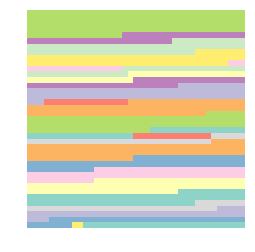

In [161]:
i = 0
j = 0
color = np.random.choice(len(chr_counts), len(chr_counts), replace=False)
for chr_count in chr_counts:
    chrs_img[i:i+chr_count] = np.ones(chr_count)*color[j]
    j += 1
    i += chr_count

plt.imshow(chrs_img.reshape(width_height, width_height), cmap='Set3')
plt.axis('off')
#plt.legend()

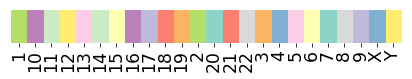

In [205]:
plt.figure(figsize=(7,2))
plt.imshow(np.array([color, color]), cmap='Set3', origin='upper')
#plt.set_xticks(chr_counts.index)
plt.xticks(range(len(chr_counts.index)),list(chr_counts.index), fontsize='xx-large', rotation=90)
plt.yticks([])
plt.box(False)

In [182]:
list(chr_counts.index)

['1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'X',
 'Y']

In [172]:
chr_counts.index

Index(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2',
       '20', '21', '22', '3', '4', '5', '6', '7', '8', '9', 'X', 'Y'],
      dtype='object')